# Subpockets to target residue(s)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from opencadd.databases.klifs import setup_remote

from kissim.encoding import FingerprintGenerator

In [3]:
plt.style.use("seaborn")

In [4]:
HERE = Path(_dh[-1])  # noqa: F821
DATA = HERE / "../../data/"
RESULTS = HERE / "../../results/"

In [5]:
REMOTE = setup_remote()

## Load subpocket center coordinates

In [6]:
fingerprint_generator = FingerprintGenerator.from_json(RESULTS / "fingerprints_clean.json")
print(f"Number of fingerprints: {len(fingerprint_generator.data)}")
# NBVAL_CHECK_OUTPUT

Number of fingerprints: 4916


In [7]:
subpocket_centers = fingerprint_generator.subpocket_centers
subpocket_centers = subpocket_centers.stack(0)
subpocket_centers.index.names = ("structure.klifs_id", "subpocket")
subpocket_centers = subpocket_centers.reset_index()
subpocket_centers["residue.ix"] = 0
subpocket_centers

dimension,structure.klifs_id,subpocket,x,y,z,residue.ix
0,3835,center,1.023518,20.786118,36.407101,0
1,3835,dfg_region,7.406333,20.055666,33.521999,0
2,3835,front_pocket,-0.281000,16.146334,39.322002,0
3,3835,hinge_region,1.975000,21.757334,41.807003,0
4,6679,center,1.047812,21.004131,36.159405,0
...,...,...,...,...,...,...
19580,7218,hinge_region,2.058333,22.553665,42.360996,0
19581,7219,center,0.650437,21.145950,37.116161,0
19582,7219,dfg_region,8.445666,22.603998,34.847000,0
19583,7219,front_pocket,0.248667,16.351334,39.368999,0


## Define target residues

In [8]:
subpocket_to_residue_ixs = {
    "hinge_region": [46, 47, 48],
    "dfg_region": [81, 82, 83],
    "front_pocket": [4, 5, 6, 7, 8, 9],
}
subpocket_to_residue_ixs

{'hinge_region': [46, 47, 48],
 'dfg_region': [81, 82, 83],
 'front_pocket': [4, 5, 6, 7, 8, 9]}

In [9]:
residue_ix_to_subpocket = {
    residue_ix: subpocket
    for subpocket, residue_ixs in subpocket_to_residue_ixs.items()
    for residue_ix in residue_ixs
}
residue_ix_to_subpocket

{46: 'hinge_region',
 47: 'hinge_region',
 48: 'hinge_region',
 81: 'dfg_region',
 82: 'dfg_region',
 83: 'dfg_region',
 4: 'front_pocket',
 5: 'front_pocket',
 6: 'front_pocket',
 7: 'front_pocket',
 8: 'front_pocket',
 9: 'front_pocket'}

## Load pocket residue CA atom coordinates

In [10]:
ca_atoms = pd.read_csv(
    DATA / "processed/pocket_residue_ca_atom_coordinates.csv.gz", header=0, index_col=[0, 1]
)
# Rename a few columns and reset index
ca_atoms = ca_atoms.rename(columns={"atom.x": "x", "atom.y": "y", "atom.z": "z"})
ca_atoms = ca_atoms.reset_index()
# Keep only target residues
ca_atoms = ca_atoms[ca_atoms["residue.ix"].isin(residue_ix_to_subpocket.keys())]
# Add subpocket name
ca_atoms["subpocket"] = ca_atoms.apply(lambda x: residue_ix_to_subpocket[x["residue.ix"]], axis=1)
# Keep only structures that we have subpocket centers for
ca_atoms = ca_atoms[
    ca_atoms["structure.klifs_id"].isin(subpocket_centers["structure.klifs_id"].unique())
]
ca_atoms

,structure.klifs_id,residue.ix,x,y,z,subpocket
3,3835,4,3.490,11.680,43.584,front_pocket
4,3835,5,6.190,10.086,41.438,front_pocket
5,3835,6,5.019,9.935,37.805,front_pocket
6,3835,7,6.529,10.559,34.367,front_pocket
7,3835,8,10.277,10.733,35.148,front_pocket
...,...,...,...,...,...,...
412144,7219,47,-0.478,23.541,46.525,hinge_region
412145,7219,48,-3.728,21.939,45.542,hinge_region
412178,7219,81,2.003,19.768,33.851,dfg_region
412179,7219,82,3.749,21.637,31.096,dfg_region


## Concatenate CA atom and subpocket center data

In [11]:
coordinates = (
    pd.concat([ca_atoms, subpocket_centers])
    .sort_values(["structure.klifs_id", "subpocket"])
    .reset_index(drop=True)
)
coordinates.index.name = "ix"
coordinates

,structure.klifs_id,residue.ix,x,y,z,subpocket
ix,,,,,,
0,1,0,0.783500,22.267733,37.174877,center
1,1,81,0.495000,19.480000,32.809000,dfg_region
2,1,82,3.266000,17.284000,34.243000,dfg_region
3,1,83,5.132000,16.924000,30.908000,dfg_region
4,1,0,7.576667,23.035334,34.537666,dfg_region
...,...,...,...,...,...,...
76368,13039,0,0.374667,15.886001,38.837666,front_pocket
76369,13039,46,-0.116000,25.993000,43.704000,hinge_region
76370,13039,47,-0.687000,23.260000,46.279000,hinge_region


## Get vector between subpocket centers and their target residue CA atoms

In [12]:
vectors = coordinates.groupby(["structure.klifs_id", "subpocket"]).apply(
    lambda group: group[group["residue.ix"] != 0][["x", "y", "z"]]
    - group[group["residue.ix"] == 0][["x", "y", "z"]].squeeze()
)
vectors = (
    vectors.reset_index()
    .merge(coordinates.reset_index()[["ix", "residue.ix"]], how="left", on="ix")
    .set_index(["structure.klifs_id", "subpocket", "residue.ix"])
    .drop("ix", axis=1)
)
vectors

x         y         z
structure.klifs_id subpocket    residue.ix                               
1                  dfg_region   81          -7.081667 -3.555334 -1.728666
                                82          -4.310667 -5.751334 -0.294666
                                83          -2.444667 -6.111334 -3.629666
                   front_pocket 4            6.476667 -2.891666  4.076000
                                5            9.694667 -3.674666  2.196000
...                                               ...       ...       ...
13039              front_pocket 8           11.357333 -5.099001 -4.288666
                                9           11.522333 -5.779001 -0.545666
                   hinge_region 46          -1.940667  4.001667  1.552000
                                47          -2.511667  1.268667  4.127000
                                48          -5.561667 -0.799333  3.191000

[56788 rows x 3 columns]

## Get vector length (distance)

In [13]:
distances = vectors.apply(lambda x: np.linalg.norm(x), axis=1)
distances = distances.unstack(0).transpose()
distances

subpocket          dfg_region                     front_pocket             \
residue.ix                 81        82        83           4          5    
structure.klifs_id                                                          
1                    8.110407  7.193505  7.516600     8.180631  10.597743   
2                    6.898398  6.630135  5.233401     7.643106   9.226015   
8                    6.393397  8.394686  6.744004     7.559248   9.617310   
11                   7.237975  8.515901  6.093379     8.357121  10.724409   
15                   7.151968  8.723244  8.077608     9.000510   9.633533   
...                       ...       ...       ...          ...        ...   
13029                6.632046  7.286784  6.493510     8.814440   8.953579   
13034                7.573400  7.109609       NaN     8.774818   8.304204   
13035                6.617200  7.300569  6.497056     8.801817   8.811314   
13037                5.916974  5.814752  4.403840     7.902278   8.361583   
13039                5.864353  5.989305  4.978625     7.292395   7.974901   

subpocket                                                      hinge_region  \
residue.ix                 6          7          8          9            46   
structure.klifs_id                                                            
1                         NaN  11.408242  13.840989  13.290591     4.977981   
2                    8.499768  11.158973  12.884595  12.569585     4.984943   
8                    9.839860        NaN        NaN  10.673312     5.121003   
11                  12.973671  14.884654  12.919863  12.291550     5.196987   
15                   7.539253   9.834125  11.270214  11.669971     4.710091   
...                       ...        ...        ...        ...          ...   
13029                7.802783  10.137551  10.797569   9.850385     4.382499   
13034                7.723028   9.384902   9.505375  10.400014     5.258348   
13035                7.857125  10.107912  10.738866   9.814631     4.513941   
13037                6.621249   9.411914  13.043503  13.281824     4.555748   
13039                7.451893  10.378291  13.167440  12.901890     4.710438   

subpocket                               
residue.ix                47        48  
structure.klifs_id                      
1                   4.987418  6.200912  
2                   5.078646  6.253747  
8                   5.351008  6.489459  
11                  5.194417  6.448320  
15                  5.085317  6.340704  
...                      ...       ...  
13029               4.721105  6.743289  
13034               5.287952  6.910510  
13035               4.656369  6.700333  
13037               5.070702  6.661069  
13039               4.995009  6.461698  

[4916 rows x 12 columns]

## Plot distance distributions

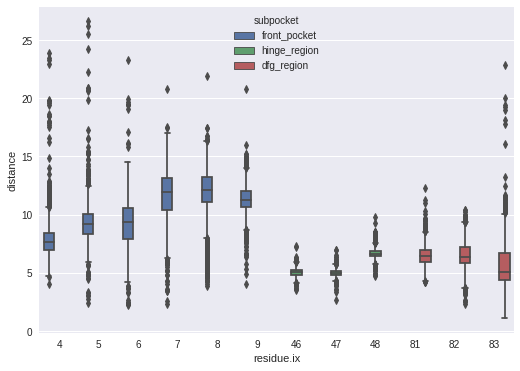

In [14]:
plt.figure(figsize=(8.5, 6))
ax = sns.boxplot(
    x="residue.ix",
    y="distance",
    hue="subpocket",
    data=distances.melt().sort_values("residue.ix").rename(columns={"value": "distance"}),
)

## Plot distance distributions split by DFG conformation

In [15]:
structures = REMOTE.structures.all_structures()

In [16]:
structure_klifs_ids_by_dfg = {
    name: group["structure.klifs_id"].to_list()
    for name, group in structures.groupby("structure.dfg")
}
distances_dict = {
    "All": distances,
    "DFG-in": distances[distances.index.isin(structure_klifs_ids_by_dfg["in"])],
    "DFG-out": distances[distances.index.isin(structure_klifs_ids_by_dfg["out"])],
}

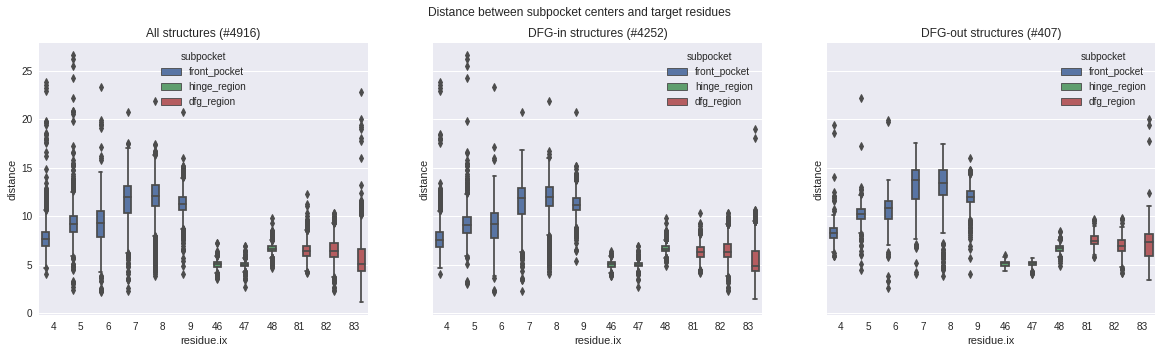

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
fig.suptitle("Distance between subpocket centers and target residues")
for i, (title, data) in enumerate(distances_dict.items()):
    sns.boxplot(
        x="residue.ix",
        y="distance",
        hue="subpocket",
        data=data.melt().sort_values("residue.ix").rename(columns={"value": "distance"}),
        ax=axes[i],
    )
    axes[i].set_title(f"{title} structures (#{len(data)})")